In [1]:
import numpyro
numpyro.set_platform("cpu")
#numpyro.set_platform("gpu")

In [2]:
import numpy as np

この例では、phaseとノイズレベルsigmaを推定します。観測値はy=sin(x + phase)です。

In [3]:
np.random.seed(32)
phase=0.5
sigin=0.3
N=100
x=np.sort(np.random.rand(N))*4*np.pi
y=np.sin(x+phase)+np.random.normal(0,sigin,size=N)

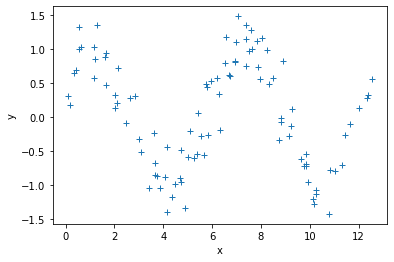

In [4]:
import matplotlib.pyplot as plt
plt.plot(x,y,"+",color="C0")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("hmc1.pdf")

In [5]:
import celerite2
import jax.numpy as jnp

In [6]:
from celerite2.jax import GaussianProcess
from celerite2.jax import terms
from jax.config import config
config.update('jax_enable_x64', True)

celerite2.jax only works with dtype float64. We're enabling x64 now, but you might run into issues if you've already run some jax code.
You can squash this warning by setting the environment variable 'JAX_ENABLE_X64=True' or by running:
>>> from jax.config import config
>>> config.update('jax_enable_x64', True)


In [7]:
kernel = terms.Matern32Term(sigma=1.0, rho=1.0)
mu=jnp.sin(x+0.5)
gp = GaussianProcess(kernel, mean=mu)
gp.compute(x)


In [8]:
gp.log_likelihood(y)

DeviceArray(-24428.73249437, dtype=float64)

In [9]:
import matplotlib.pyplot as plt
#plt.plot(x,y)

In [17]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax.config import config
config.update('jax_enable_x64', True)
#config.update('jax_enable_x64', False)

def model(x,y):
    lna = numpyro.sample("lna", dist.Uniform(low=-2, high=2))
    lnc = numpyro.sample("lnc", dist.Uniform(low=-1.5, high=1.5))
    phase = numpyro.sample('phase', dist.Uniform(-1.0*jnp.pi, 1.0*jnp.pi))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    
    mu=jnp.sin(x+phase)
    
    kernel = terms.Matern32Term(sigma=jnp.exp(lna), rho=jnp.exp(lnc))
    #kernel = terms.Matern32Term(sigma=10.0, rho=1.0)
    gp = GaussianProcess(kernel, mean=mu)
    gp.compute(x)
    gploglike=gp.log_likelihood(y)
    
    
    loglikelihood=-0.5*(y-mu)**2/sigma**2-jnp.log(sigma)
    numpyro.factor("loglike", loglikelihood+gploglike)
    #numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [18]:
from jax import random
from numpyro.infer import MCMC, NUTS

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model, dense_mass=True)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, x=x, y=y)
mcmc.print_summary()

sample: 100%|█| 3000/3000 [00:03<00:00, 756.52it/s, 7 steps of size 5.94e-01. ac



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       lna      0.90      0.01      0.90      0.89      0.91   2033.06      1.00
       lnc     -1.50      0.00     -1.50     -1.50     -1.50   1868.91      1.00
     phase      0.48      0.03      0.48      0.42      0.53   1961.88      1.00
     sigma      0.30      0.02      0.30      0.26      0.33   2039.84      1.00

Number of divergences: 0


In [19]:
samples = mcmc.get_samples()
samples["phase"]

DeviceArray([0.53487851, 0.47904581, 0.45701897, ..., 0.47608195,
             0.47956476, 0.5572628 ], dtype=float64)

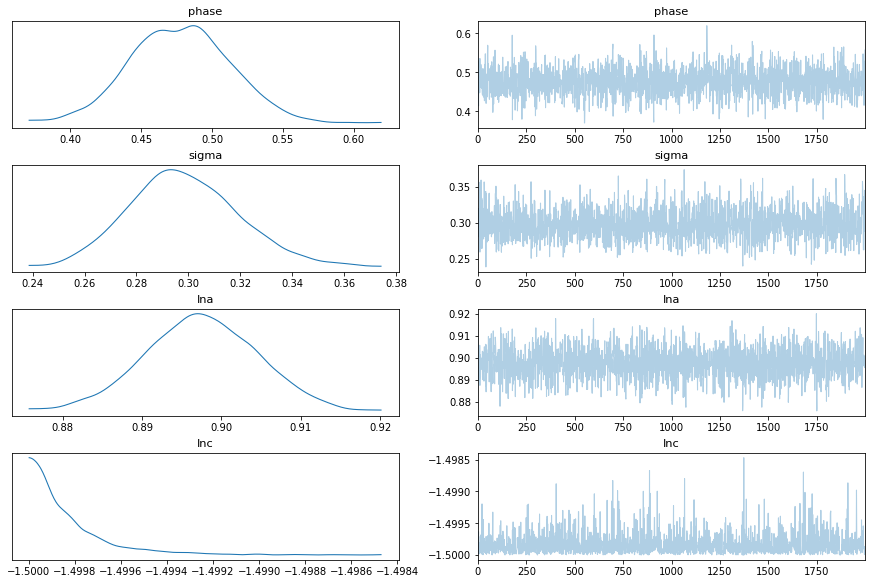

In [21]:
import arviz
arviz.plot_trace(mcmc, var_names=["phase","sigma","lna","lnc"])
plt.savefig("hmc2.pdf")

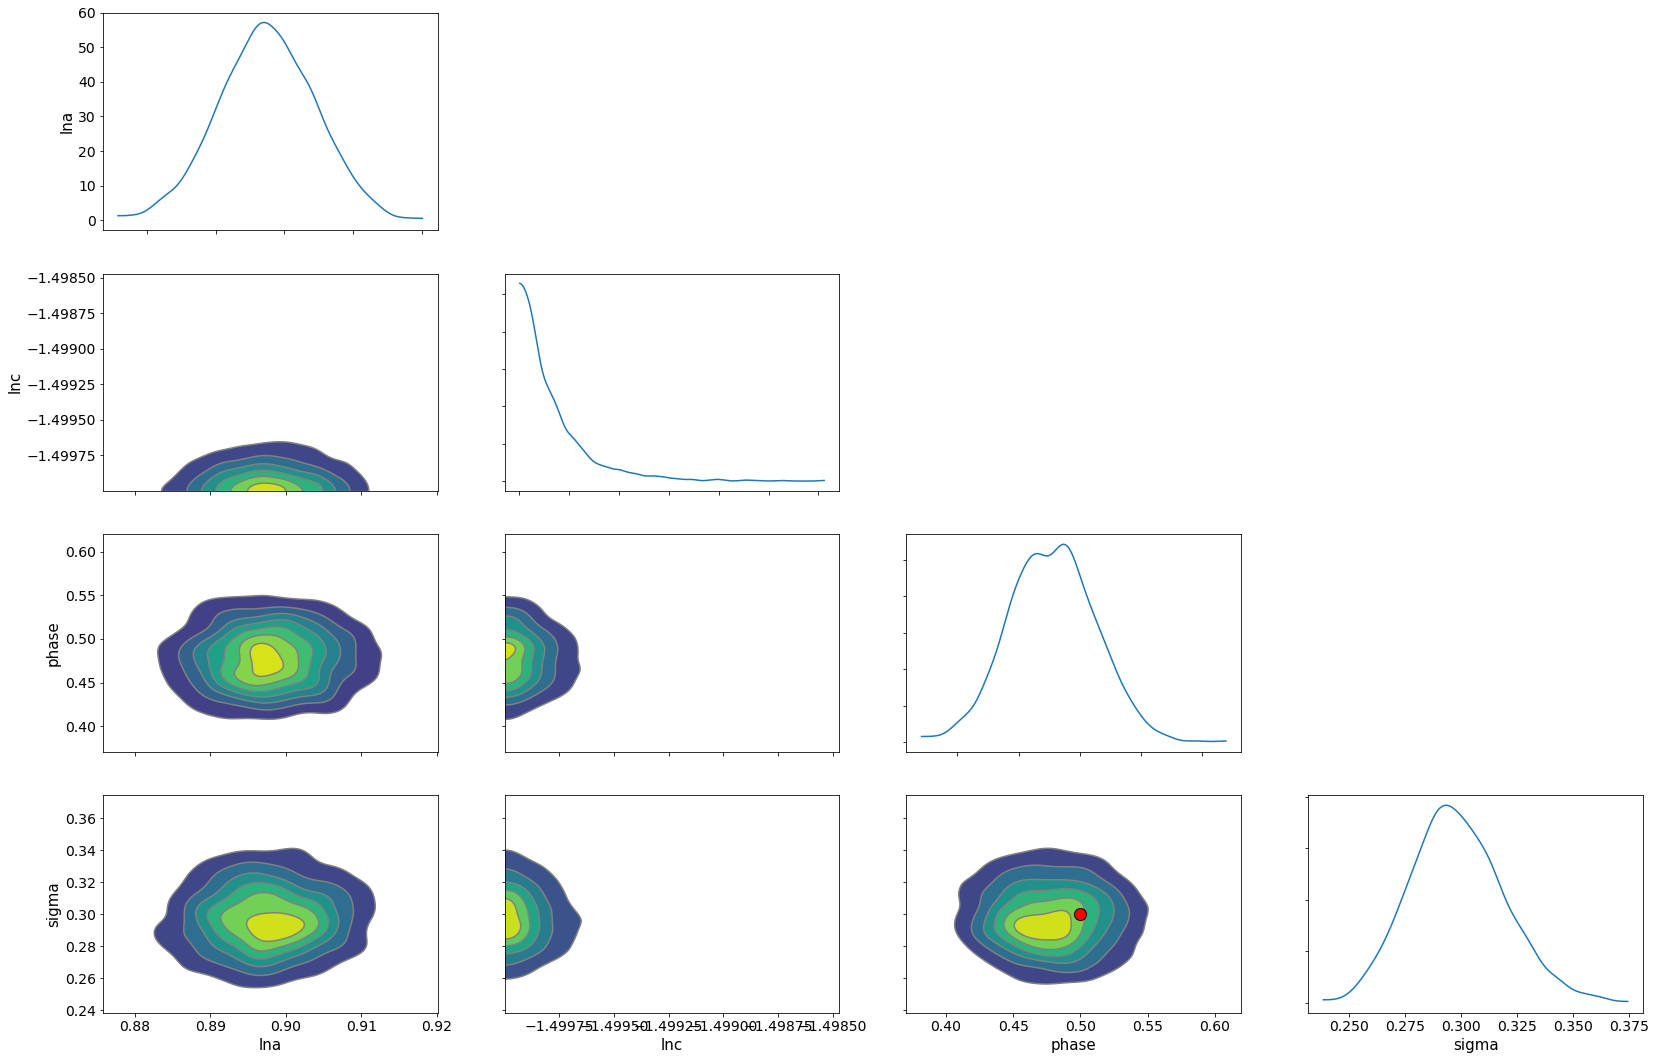

In [24]:
refs={};refs["sigma"]=sigin;refs["phase"]=phase;refs["lna"]=1.0;refs["lnc"]=1.0
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',
    divergences=False,marginals=True,reference_values=refs,
    reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("hmc3.pdf", bbox_inches="tight", pad_inches=0.0)

In [29]:
posterior_phase = mcmc.get_samples()['phase']
posterior_sigma = mcmc.get_samples()['sigma']
posterior_lna = mcmc.get_samples()['lna']
posterior_lnc = mcmc.get_samples()['lnc']

In [30]:
posterior_phase

DeviceArray([0.53487851, 0.47904581, 0.45701897, ..., 0.47608195,
             0.47956476, 0.5572628 ], dtype=float64)

In [34]:
from numpyro.infer import Predictive
pred = Predictive(model,{'phase':posterior_phase,'sigma':posterior_sigma, 'lna':posterior_lna, 'lnc':posterior_lnc},return_sites=["y"])
x_ = jnp.linspace(0,4*jnp.pi,1000)
predictions = pred(rng_key_,x=x_,y=None)

ValueError: 'y' must be one dimensional

In [35]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(predictions["y"], axis=0)
hpdi_muy = hpdi(predictions["y"], 0.9)

NameError: name 'predictions' is not defined

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


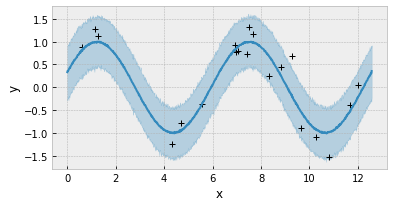

In [12]:
import seaborn as sns
plt.style.use('bmh')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(x,y,"+",color="black")
ax.plot(x_,mean_muy,color="C0")
ax.fill_between(x_, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("hmc4.pdf")